<a href="https://colab.research.google.com/github/Mancupfire/VinIndoorCare/blob/main/Latest_SPATIAL(Sensor_Prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import itertools
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Masking
from tensorflow.keras.layers import Input, Permute
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [ ]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
def flattern(p):
    pred_y_matrix = [[] for _ in range(len(p[0]))]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix


def interpolate(data, mask=-1):
    temp = [list(dd) for dd in data]
    d = []
    for i in range(len(temp)):
        # biến mask thành NaN để interpolate
        arr = [np.nan if x == mask else x for x in temp[i]]
        df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
        d.append(df.tolist())
    return d


def data_split(dat, train_hour, test_hour, predict_position, stride):
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    length = len(dat[0])
    while i + period <= length:
        x_temp, y_temp = [], []
        for series in dat:
            x_temp.append(series[i : i + train_hour])
            y_temp.append(series[
                i + train_hour + predict_position :
                i + train_hour + predict_position + test_hour
            ])
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)


def split_train(int_dat, norm_dat, T1, T2, T3, stride, start, end, data_name=None):
    length = len(int_dat[0])
    s = int(length * start)
    e = int(length * end)

    # X train: normalize toàn bộ (loại đoạn test s:e), X test: lấy interpolate trên bản int_dat
    Train = [serie[:s] + serie[e:] for serie in norm_dat]
    Test = [serie[s:e] for serie in int_dat]

    print(f'Training series length: {len(Train[0])}; Test series length: {len(Test[0])}')
    train_x, train_y = data_split(Train, T1, T2, T3, stride)
    test_x, test_y = data_split(Test,  T1, T2, T3, stride)
    return train_x, train_y, test_x, test_y


def data_normalize(Dat, mask=-1):
    new_dat = []
    scaling = []
    for d in Dat:
        valid = [v for v in d if v != mask]
        mn = np.min(valid) if valid else 0
        mx = np.max(valid) if valid else 1
        normed = [(v - mn) / (mx - mn) if v != mask and mx != mn else v
                  for v in d]
        new_dat.append(normed)
        scaling.append((mn, mx))
    return new_dat, scaling


In [ ]:
def evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start):
    results = {}
    for i, var in enumerate(variable_names):
        mn, mx = scaling_params[i]
        # reshape về 1d để evaluate
        pred_flat = pred_y[:, i, 0].ravel() * (mx - mn) + mn
        true_flat = test_y[:,i,0].ravel() * (mx - mn) + mn

        # xác định time axis
        s = int(len(time_index) * start)
        dates = pd.date_range(
            start=time_index[s],
            periods=len(pred_flat),
            freq=time_index[1] - time_index[0]
        )

        # tìm shift tối ưu
        metrics = []
        for sh in range(-20,1):
            sp = np.roll(pred_flat, sh)
            if sh<0: sp[sh:] = sp[sh-1]
            mae  = mean_absolute_error(true_flat, sp)
            rmse = np.sqrt(mean_squared_error(true_flat, sp))
            r2   = r2_score(true_flat, sp)
            mape = mean_absolute_percentage_error(true_flat+1e-10, sp+1e-10)*100
            metrics.append((sh, mae, rmse, r2, mape))
        best = min(metrics, key=lambda x: x[1])
        sh, mae0, rmse0, r20, mape0 = best

        plt.figure(figsize=(12,5))
        plt.plot(dates, np.roll(pred_flat, sh), label=f'Pred (shift {sh})')
        plt.plot(dates, true_flat, label='True')
        plt.legend(); plt.title(var); plt.tight_layout(); plt.show()

        print(f"\n{var} -> MAE:{mae0:.4f}, RMSE:{rmse0:.4f}, R²:{r20:.4f}, MAPE:{mape0:.2f}% (shift={sh})")

        results[var] = {
            'MAE': mae0, 'RMSE': rmse0, 'R2': r20, 'MAPE': mape0, 'shift': sh
        }
    return results

Predict 4 using 1,2,3

In [ ]:
def load_and_align_data(sensor_files, variables, mask=-1):
    # --- như trước ---
    data, variable_names, time_index = [], [], None
    for _, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        time_index = df.index if time_index is None else time_index.intersection(df.index)
    for name, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        for var in variables:
            if var in df.columns:
                data.append(df.loc[time_index, var].tolist())
                variable_names.append(f"{name}_{var}")
    return data, variable_names, time_index

def spatio_temporal_model(train_time, n_sensors, out_horizon, tempor_units=64, spatial_units=32, lr=1e-4,):
    inp = Input(shape=(train_time, n_sensors))
    t = Bidirectional(LSTM(tempor_units, return_sequences=True))(inp)
    s = Permute((2,1))(t)
    s = Bidirectional(LSTM(spatial_units, return_sequences=False))(s)
    # Dense đầu ra: out_horizon * n_sensors
    flat_out = Dense(out_horizon * n_sensors)(s)

    m = Model(inputs=inp, outputs=flat_out)
    m.compile(
      loss="mean_absolute_error",
      optimizer=Adam(learning_rate=lr)
    )
    return m



In [ ]:
def compute_spatial_weights(sensor_positions, exponent=1.0, eps=1e-6):
    names = list(sensor_positions.keys())
    coords = np.array([sensor_positions[n] for n in names])
    # ma trận khoảng cách
    dist = np.linalg.norm(coords[:,None,:] - coords[None,:,:], axis=-1)
    W = 1.0 / (dist**exponent + eps)
    np.fill_diagonal(W, 0.)
    # chuẩn hóa hàng thành xác suất
    return W / (W.sum(axis=1, keepdims=True) + eps), names

In [ ]:
def compute_target_weights(sensor_positions, target_position, exponent=1.0, eps=1e-6):
    coords = np.array(list(sensor_positions.values()))
    dist = np.linalg.norm(coords - np.array(target_position), axis=1)
    w = 1.0 / (dist**exponent + eps)
    return w / (w.sum() + eps)

In [ ]:
def SP_Learner_3to1(
    data_in, data_out,
    train_time, test_time, pred_pos, stride, start, end,
    sensor_positions, target_position,
    tempor_units=64, spatial_units=32, exponent=1.0, lr=1e-4
):
    norm_in, _         = data_normalize(data_in)
    interp_in          = interpolate(norm_in, mask=-1)
    norm_out, scale_out= data_normalize(data_out)
    interp_out         = interpolate(norm_out, mask=-1)

    tx, _, vx, _ = split_train(interp_in,  norm_in,
                                train_time, test_time, pred_pos,
                                stride, start, end)
    _, ty, _, vy = split_train(interp_out, norm_out,
                                train_time, test_time, pred_pos,
                                stride, start, end)

    train_x = tx.transpose(0, 2, 1)
    val_x   = vx.transpose(0, 2, 1)

    W_norm, _    = compute_spatial_weights(sensor_positions, exponent)
    w_target     = compute_target_weights(sensor_positions, target_position, exponent)

    neigh_train  = train_x @ W_norm.T              # (N, T, sensors)
    neigh_val    = val_x   @ W_norm.T
    targ_train   = np.tensordot(train_x, w_target, axes=([2],[0]))  # (N, T)
    targ_val     = np.tensordot(val_x,   w_target, axes=([2],[0]))

    train_in = np.concatenate([train_x, neigh_train, targ_train[...,None]], axis=2)
    val_in   = np.concatenate([  val_x,   neigh_val,   targ_val[...,None]], axis=2)

    model = spatio_temporal_model(
        train_time,
        n_sensors=train_in.shape[2],
        out_horizon=test_time,
        tempor_units=tempor_units,
        spatial_units=spatial_units,
        lr=lr,
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    with tf.device('/GPU:0'):
        model.fit(
            train_in,
            ty[:,0,:],        # flatten target: (N, test_time)
            epochs=50,
            batch_size=16,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

    pred_flat = model.predict(val_in, verbose=1)
    pred = pred_flat[:, None, :]  # (N, 1, test_time)

    return pred, vy, model, scale_out

<ipython-input-35-84a91d9f3334>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Training series length: 93891; Test series length: 23473
Training series length: 93891; Test series length: 23473
Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.0927 - val_loss: 0.0243
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0367 - val_loss: 0.0238
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0332 - val_loss: 0.0224
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0315 - val_loss: 0.0196
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0305 - val_loss: 0.0187
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0296 - val_loss: 0.0196
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0296 - val_loss: 0.0182
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0287 - val_loss: 0.0191
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0290 - val_loss: 0.0178
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0286 - val_loss: 0.0185
Epoch

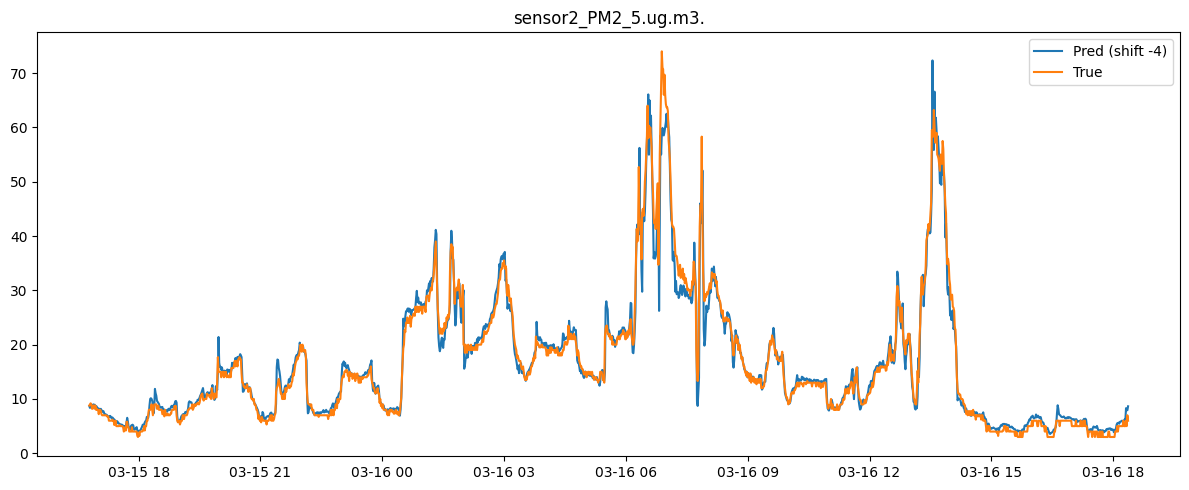


sensor2_PM2_5.ug.m3. -> MAE:1.2778, RMSE:2.1553, R²:0.9691, MAPE:9.34% (shift=-4)
{'sensor2_PM2_5.ug.m3.': {'MAE': 1.2778266749572749, 'RMSE': np.float64(2.1552905283397004), 'R2': 0.9691083889750937, 'MAPE': 9.339866035740663, 'shift': -4}}


In [ ]:
if __name__ == "__main__":
    # 1) Các tham số chung
    train_time   = 335
    test_time    = 30
    pred_pos     = 70
    stride       = 15
    start, end   = 0.8, 1.0
    variables    = ['PM2_5.ug.m3.']
    base_path    = '/content/1_mins/'
    all_sensors  = {
        'sensor1': f'{base_path}01_01mins.csv',
        'sensor2': f'{base_path}02_01mins.csv',
        'sensor3': f'{base_path}03_01mins.csv',
        'sensor4': f'{base_path}04_01mins.csv',
    }

    data_all, names_all, time_index = load_and_align_data(all_sensors, variables)
    data_in  = [data_all[i] for i in [0, 2, 3]]
    data_out = [data_all[1]]

    sensor_positions = {
        'sensor1': (0.0, 0.0),
        'sensor2': (1.0, 0.0),
        'sensor3': (0.5, 0.8),
    }
    target_position = (0.3, 0.4)
    exponent = 2.0  # thay đổi độ nhạy với khoảng cách

    pred_y, true_y, model, scaling = SP_Learner_3to1(
        data_in, data_out, train_time, test_time, pred_pos, stride,
        start, end, sensor_positions, target_position, tempor_units=64,
        spatial_units=32, exponent=exponent, lr=1e-4,
    )

    preds = pred_y[:, :, 0]
    print("=== Các giá trị dự đoán cho sensor2 ===")
    print(preds)

    import pandas as pd
    col_names = [f"step_{i+1}" for i in range(preds.shape[1])]
    df_preds = pd.DataFrame(preds, columns=col_names)
    df_preds.index.name = "window_idx"
    out_csv = "predictions_sensor2(1mins).csv"
    df_preds.to_csv(out_csv, index=True)
    print(f"Đã lưu dự đoán vào file: {out_csv}")

    res = evaluate_model(
        pred_y, true_y,
        ['sensor2_' + variables[0]],
        scaling, time_index, start
    )
    print(res)